## Analyse GTSR-gegevens

Bepaal de windopzet- (en eventueel) getij-gegevens op basis van een globaal model.

In [1]:
from netCDF4 import Dataset
# coordinate systems
import pyproj 

# plotting
import bokeh.io
import bokeh.plotting
import bokeh.tile_providers
import bokeh.palettes

import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt

# Some coordinate systems
WEBMERCATOR = pyproj.Proj(init='epsg:3857')
WGS84 = pyproj.Proj(init='epsg:4326')

# If this notebook is not showing up with figures, you can use the following url:
# https://nbviewer.ipython.org/github/openearth/notebooks/blob/master/sealevelmonitor.ipynb
bokeh.io.output_notebook()
# we're using matplotlib for polar plots (non-interactive)
%matplotlib inline
# does not work properly
# %matplotlib notebook


Loading BokehJS ...

Define the datasets

In [2]:
ds = {
    'tide': Dataset('d:/Documents/2695.50 Zeespiegelstijging 2018/Data/FES2012_tide_NorthSea_zeespiegelmonitor.nc', 'r'),
    'surge': Dataset('d:/Documents/2695.50 Zeespiegelstijging 2018/Data/GTSR_surge_NorthSea_zeespiegelmonitor.nc', 'r')
}

The datasets (altough not similar) contain the following data:

In [3]:
list(ds['tide'].variables.keys())

['tide',
 'time',
 'station_name',
 'station_id',
 'station_available',
 'station_y_coordinate',
 'station_x_coordinate',
 'crs']

Get some data like names and coordinates from both sets

In [4]:
# Derive station names
station_names = []
for station in ds['tide'].variables['station_name'][:]:#.data.T:
    station_names.append(''.join([s.decode() for s in station]))

In [5]:
# Get coordinates
coordinates = {}
for quantity in ['tide', 'surge']:
    coordinates[quantity] = np.vstack([
        ds[quantity].variables['station_x_coordinate'][:].data,
        ds[quantity].variables['station_y_coordinate'][:].data
    ]).T


To get an overview of the tide station locations in relation to the model output locations, we plot both:

In [6]:
# show all the stations on a map

# compute the bounds of the plot
sw = (51, 3)
ne = (54, 6)
# transform to web mercator
sw_wm = pyproj.transform(WGS84, WEBMERCATOR, sw[1], sw[0])
ne_wm = pyproj.transform(WGS84, WEBMERCATOR, ne[1], ne[0])
# create a plot
fig = bokeh.plotting.figure(tools='pan, wheel_zoom', plot_width=600, plot_height=600, x_range=(sw_wm[0], ne_wm[0]), y_range=(sw_wm[1], ne_wm[1]))
fig.axis.visible = False
# add some background tiles
fig.add_tile(bokeh.tile_providers.STAMEN_TERRAIN)
# add the stations
x, y = pyproj.transform(WGS84, WEBMERCATOR, np.array(coordinates['tide'][:, 0]), np.array(coordinates['tide'][:, 1]))
fig.circle(x, y);

In [7]:
# Add tide stations
tide_stations = [
    [51.442222, 3.596111, 'VLISSINGEN'],
    [51.977500, 4.120000, 'HOEK VAN HOLLAND'],
    [52.964444, 4.745000, 'DEN HELDER'],
    [53.326389, 6.933056, 'DELFZIJL'],
    [53.175556, 5.409444, 'HARLINGEN'],
    [52.462222, 4.554722, 'IJMUIDEN']
]

tide_coords = np.array([station[:2] for station in tide_stations])
st_x, st_y = pyproj.transform(WGS84, WEBMERCATOR, np.array(tide_coords)[:, 1], np.array(tide_coords)[:, 0])
fig.circle(st_x, st_y, color='red', size=7, alpha=0.3);


In [8]:
# show the plot
bokeh.io.show(fig)

For most stations there is a nearby model output location, which we will assume representative. Only for Delfzijl there is no nearby location. We will still use the nearest location, but keep in mind that this might give unrepresentative data.

In [9]:
# find nearest (roughly) station and get data
def find_station_index(model_crds, tide_stations):
    index = [np.hypot(coordinates[quantity][:, 0] - station[1], coordinates[quantity][:, 1] - station[0]).argmin()
             for station in tide_stations]
    return index

# Get tide data
data = ds['tide'].variables['tide'][:, find_station_index(coordinates['tide'], tide_stations)]
values = data.data
values[values > 1000.0] = np.nan
values[~data.mask] = np.nan

# Create time series
start_date = datetime.datetime.strptime(ds['tide']['time'].units.split()[2], '%Y-%m-%d')
time = start_date + np.array([datetime.timedelta(seconds=minutes) for minutes in ds['tide'].variables['time'][:] * 60])

tide = pd.DataFrame(
    data=values,
    index=time,
    columns=[station[-1].lower().capitalize() for station in tide_stations]
)

# Get values
data = ds['surge'].variables['waterlevel'][:, find_station_index(coordinates['surge'], tide_stations)]

# Construct time index
time = [datetime.datetime.fromordinal(int(ts)) + datetime.timedelta(seconds=round((ts % 1) * 86400)) for ts in ds['surge']['time'][:]]

surge = pd.DataFrame(
    data=data,
    index=time,
    columns=[station[-1].lower().capitalize() for station in tide_stations]
)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less_equal
  from ipykernel import kernelapp as app
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


In [10]:
tide.head()

,Vlissingen,Hoek van holland,Den helder,Delfzijl,Harlingen,Ijmuiden
1979-01-01 00:00:00,0.285,-0.809,-0.664,1.436,-0.071,-0.912
1979-01-01 00:10:00,0.499,-0.787,-0.712,1.372,-0.107,-0.935
1979-01-01 00:20:00,0.716,-0.745,-0.764,1.295,-0.139,-0.944
1979-01-01 00:30:00,0.930,-0.681,-0.820,1.206,-0.170,-0.935
1979-01-01 00:40:00,1.137,-0.595,-0.876,1.109,-0.202,-0.909


In [11]:
surge.head()

,Vlissingen,Hoek van holland,Den helder,Delfzijl,Harlingen,Ijmuiden
1980-01-02 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1980-01-02 00:10:00,-0.000249,0.000590,0.000806,-0.003677,-0.002944,-0.000753
1980-01-02 00:20:00,-0.000890,0.001760,0.003596,-0.011441,-0.005254,-0.002288
1980-01-02 00:30:00,-0.001303,0.002308,0.007541,-0.016545,-0.004505,-0.003557
1980-01-02 00:40:00,-0.001141,0.001128,0.010611,-0.014177,-0.005693,-0.004845


In [12]:
surge.mean()

Vlissingen         -0.030393
Hoek van holland   -0.015394
Den helder          0.003117
Delfzijl            0.026735
Harlingen           0.014591
Ijmuiden           -0.004340
dtype: float64

We plot the tide and surge for a station during one month.

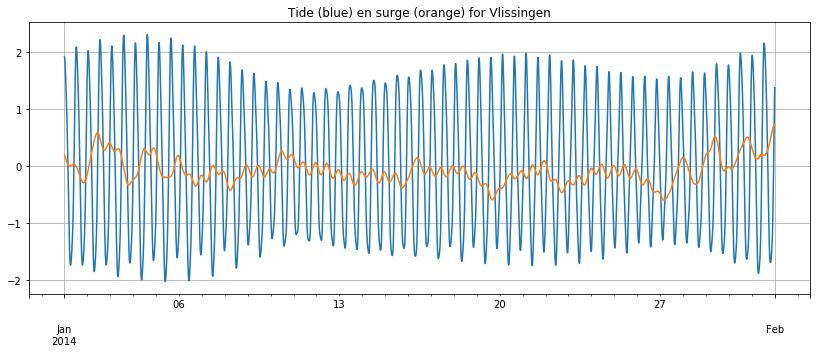

In [13]:
fig, ax = plt.subplots(figsize=(14, 5))
station = 'Vlissingen'
st_tide = tide.loc[datetime.datetime(2014, 1, 1):datetime.datetime(2014, 2, 1), station]
st_surge = surge.loc[datetime.datetime(2014, 1, 1):datetime.datetime(2014, 2, 1), station]

st_tide.plot(ax=ax)
st_surge.plot(ax=ax)
ax.grid()

ax.set_title(f'Tide (blue) en surge (orange) for {station}');

The figure below gives the 

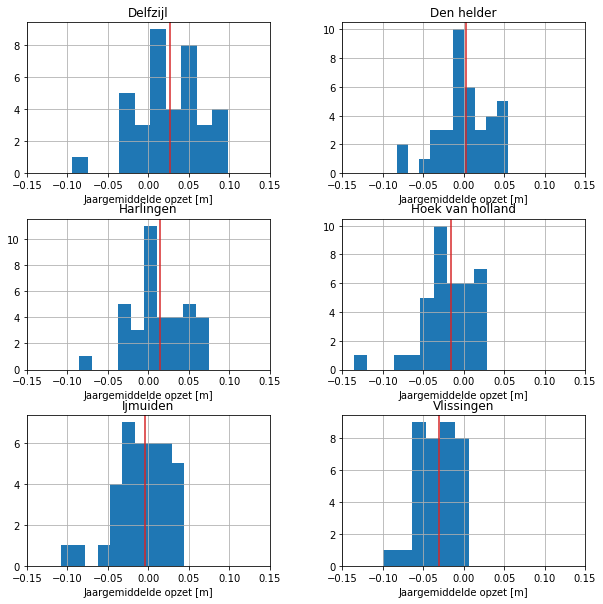

In [14]:
axs = surge.groupby(surge.index.year).mean().hist(figsize=(10, 10))
for mean, ax in zip(surge.mean().sort_index().values, axs.ravel()):
    ax.set_xlim(-.15, .15)
    ax.set_xlabel('Jaargemiddelde opzet [m]')
    ax.set_ylim(ax.get_ylim())
    ax.plot([mean]*2, ax.get_ylim(), color='C3')

Noteworthy is that the spread over the different years is a few centimeters.

Save the data as pickle to be loaded in a different notebook.

In [16]:
surge.to_pickle('../Data/surge.pkl')